In [1]:
%pylab inline
%gui qt

Populating the interactive namespace from numpy and matplotlib


### Load Sorted Data

In [2]:
from spiketag.mvc import Sorter

In [3]:
app = Sorter('/mnt/ramdisk/pcie.bin', '/mnt/ramdisk/pcie_spktag.bin')

[INFO/MainProcess] load mua data


#############  load data  ###################
/mnt/ramdisk/pcie.bin loaded, it contains: 
30150587 * 32 points (3859275136 bytes) 
32 channels with sampling rate of 25000.0000 
1206.023 secs (20.100 mins) of data
#############################################


[INFO/MainProcess] load spktag file


In [4]:
app.run()

### Learn a new linear projection: LDA

In [5]:
import numpy as np
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

In [40]:
X = app.fet
y = app.clu.membership

In [7]:
lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=3)
lda.fit(X,y)

LinearDiscriminantAnalysis(n_components=3, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [8]:
newfet = np.dot(X, lda.scalings_)

In [66]:
newfet = np.dot(newfet, np.linalg.inv(lda.scalings_))

In [9]:
newfet = newfet/-newfet.min()

In [12]:
app.fet = newfet

In [10]:
correct_labels = y

In [52]:
labels = lda.predict(X)

In [11]:
lda.score(X, correct_labels)

0.99121996303142335

## Classification
### cross-validation

In [87]:
import seaborn as sns
from sklearn import cross_validation

In [88]:
X = app.fet
y = app.clu.membership

In [89]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.8, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8928, 3), (8928,), (35715, 3), (35715,))

#### 1. LDA

In [90]:
lda.fit(X_train, y_train)
lda.score(X_test, y_test)

0.95828083438331235

In [91]:
k_folds = 10
scores = cross_validation.cross_val_score(lda, X, y, cv=k_folds)
scores

array([ 0.9218715 ,  0.95254086,  0.95789474,  0.96303763,  0.96684588,
        0.96886201,  0.97042348,  0.96930316,  0.95272238,  0.90701322])

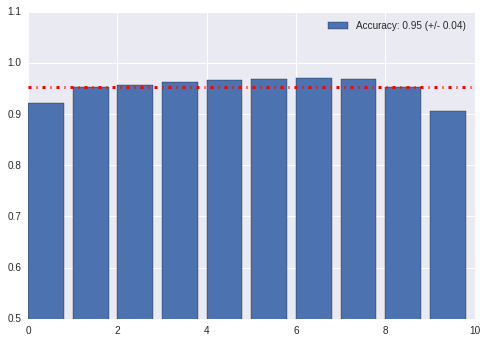

In [92]:
_ac_l = "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)
plt.bar(np.arange(k_folds), scores, label=_ac_l)
plt.axhline(scores.mean(),ls='-.', lw=3 ,c='r')
ylim(0.5,1.1)
legend(loc='best')

#### 2. SVM

In [93]:
from sklearn.svm import SVC as SVM

In [94]:
svm = SVM(kernel='linear', C=3)
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.96152876942461152

In [95]:
k_folds = 10
scores = cross_validation.cross_val_score(svm, X, y, cv=k_folds)
scores

array([ 0.91426013,  0.94828744,  0.96215006,  0.96998208,  0.97625448,
        0.98140681,  0.97983419,  0.9760251 ,  0.96907909,  0.94286354])

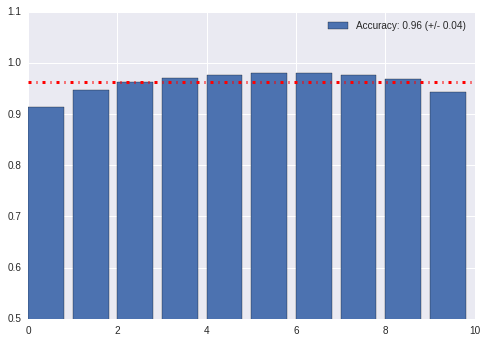

In [96]:
_ac_l = "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)
plt.bar(np.arange(k_folds), scores, label=_ac_l)
plt.axhline(scores.mean(),ls='-.', lw=3 ,c='r')
ylim(0.5,1.1)
legend(loc='best')

#### 2. KNN

In [102]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [103]:
k = 10
knn = KNN(n_neighbors=k, algorithm='kd_tree')

In [104]:
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.99031219375612489

In [105]:
k_folds = 10
scores = cross_validation.cross_val_score(knn, X, y, cv=k_folds)
scores

array([ 0.96015223,  0.99014999,  0.99529675,  0.99439964,  0.99283154,
        0.99663978,  0.9968631 ,  0.99865561,  0.99529464,  0.96751064])

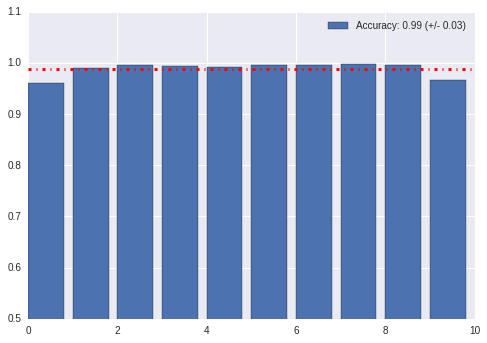

In [106]:
_ac_l = "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)
plt.bar(np.arange(k_folds), scores, label=_ac_l)
plt.axhline(scores.mean(),ls='-.', lw=3 ,c='r')
ylim(0.5,1.1)
legend(loc='best')